## TASK - 2 :  Unsupervised Learning - Air quality

In [1]:
# ISLP-style imports
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [2]:
# Load data
df = pd.read_csv("data/training_data.csv")

In [3]:
# Derive time features from DataCreationDate
df["DataCreationDate"] = pd.to_datetime(df["DataCreationDate"], errors="coerce")
df["hour"] = df["DataCreationDate"].dt.hour
df["dayofweek"] = df["DataCreationDate"].dt.dayofweek
df["month"] = df["DataCreationDate"].dt.month

In [4]:
# Define feature sets
numeric_features = [
    "SO2","CO","O3","O3_8hr","PM10","PM2.5","NO2","NOx","NO",
    "WindSpeed","CO_8hr","PM2.5_AVG","PM10_AVG","SO2_AVG",
    "hour","dayofweek","month"
]
categorical_features = ["WindDirec"]

# Column transformer: scale numerics, one-hot encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [5]:
# Fit preprocessing
X = preprocess.fit_transform(df)
feature_names_num = numeric_features
feature_names_cat = list(preprocess.named_transformers_["cat"].get_feature_names_out(categorical_features))
feature_names = feature_names_num + feature_names_cat

# Helper: safe AQI vector for profiling (not used in fitting)
aqi = df["AQI"] if "AQI" in df.columns else pd.Series([np.nan]*len(df))

In [ ]:
inertias = []
silhouettes = []

Ks = range(2, 11)
for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    #silhouette needs >1 cluster and non-degenerate
    #sil = silhouette_score(X, labels)
    #silhouettes.append(sil)

diag = pd.DataFrame({"K": Ks, "inertia": inertias, "silhouette": silhouettes})
print(diag)

    K       inertia  silhouette
0   2  1.014367e+06    0.242253
1   3  9.068273e+05    0.196877
2   4  8.431206e+05    0.124538
3   5  7.918137e+05    0.126931
4   6  7.570706e+05    0.097978
5   7  7.328936e+05    0.107397
6   8  7.068989e+05    0.095850
7   9  6.790675e+05    0.099505
8  10  6.624599e+05    0.095380


In [8]:
def fit_profile_k(k):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    df_prof = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X).copy()
    df_prof["cluster"] = labels

    # Compute means in original scale for interpretability:
    # We'll inverse-transform numerics only.
    # Build an inverse transform for numerics
    scaler = preprocess.named_transformers_["num"]
    X_num = scaler.inverse_transform(df_prof.iloc[:,:len(numeric_features)])
    X_cat = df_prof.iloc[:,len(numeric_features):-1]  # one-hot categorical
    prof_num = pd.DataFrame(X_num, columns=numeric_features)
    prof_cat = pd.DataFrame(X_cat, columns=feature_names_cat)
    prof = pd.concat([prof_num, prof_cat, df_prof[["cluster"]]], axis=1)

    summary = prof.groupby("cluster")[numeric_features].mean().round(3)

    # AQI profiling (median and quantiles)
    aqi_prof = (
        pd.DataFrame({"AQI": aqi, "cluster": labels})
        .dropna()
        .groupby("cluster")["AQI"]
        .agg(["count","mean","median","quantile"])
    )
    # quantile default needs q arg; compute specific quantiles
    aqi_prof = (
        pd.DataFrame({"AQI": aqi, "cluster": labels})
        .dropna()
        .groupby("cluster")["AQI"]
        .agg(["count","mean","median"])
        .round(2)
    )
    return km, labels, summary, aqi_prof

for k in [3,4,5]:
    km, labels, summary, aqi_prof = fit_profile_k(k)
    print(f"\n=== K={k} ===")
    print("Cluster means (numeric features):")
    print(summary)
    print("\nAQI profile:")
    print(aqi_prof)



=== K=3 ===
Cluster means (numeric features):
           SO2     CO      O3  O3_8hr    PM10   PM2.5     NO2     NOx      NO  \
cluster                                                                         
0        4.386  0.757  13.935  19.109  56.603  27.832  29.069  41.526  12.468   
1        3.383  0.410  42.726  41.715  76.367  35.124  14.043  15.636   1.599   
2        2.274  0.271  28.693  28.401  30.868  13.209   9.292  11.284   1.999   

         WindSpeed  CO_8hr  PM2.5_AVG  PM10_AVG  SO2_AVG    hour  dayofweek  \
cluster                                                                       
0            1.419   0.650     26.254    54.701    3.644  11.689      2.783   
1            2.474   0.425     34.497    74.544    3.336  12.878      3.074   
2            2.695   0.283     13.731    31.974    2.477  10.943      3.054   

         month  
cluster         
0        5.685  
1        5.974  
2        6.495  

AQI profile:
         count    mean  median
cluster              

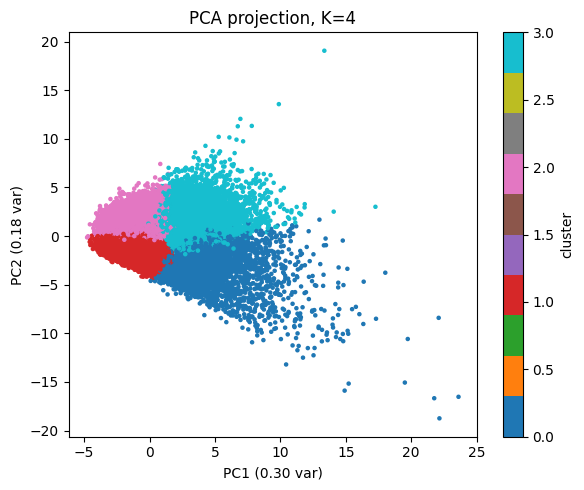

In [9]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

def plot_pca_clusters(labels, title="PCA with clusters"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=5, cmap="tab10")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2f} var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2f} var)")
    plt.title(title)
    plt.colorbar(scatter, label="cluster")
    plt.tight_layout()
    plt.show()

# Example with K=4
km4 = KMeans(n_clusters=4, n_init="auto", random_state=42).fit(X)
plot_pca_clusters(km4.labels_, title="PCA projection, K=4")


In [10]:
# 1) Correlation matrix on numeric features (original scale)
corr = df[numeric_features].corr(method="pearson")
print(corr.round(2))

# 2) K-means on variables: cluster columns by their standardized time series
# Build matrix: rows=timepoints, cols=features (numeric only)
from sklearn.preprocessing import StandardScaler

Z = StandardScaler().fit_transform(df[numeric_features])  # standardize each feature
# Transpose to cluster variables (features)
Zt = Z.T

Ks_var = range(2, 6)
for k in Ks_var:
    kmv = KMeans(n_clusters=k, n_init="auto", random_state=42)
    var_labels = kmv.fit_predict(Zt)
    groups = pd.DataFrame({"feature": numeric_features, "cluster": var_labels}).sort_values("cluster")
    print(f"\n=== Variable clusters K={k} ===")
    print(groups)


            SO2    CO    O3  O3_8hr  PM10  PM2.5   NO2   NOx    NO  WindSpeed  \
SO2        1.00  0.24  0.02   -0.01  0.24   0.25  0.37  0.33  0.16      -0.08   
CO         0.24  1.00 -0.19   -0.10  0.33   0.41  0.78  0.83  0.65      -0.25   
O3         0.02 -0.19  1.00    0.73  0.20   0.15 -0.32 -0.36 -0.30       0.33   
O3_8hr    -0.01 -0.10  0.73    1.00  0.24   0.16 -0.15 -0.24 -0.31       0.24   
PM10       0.24  0.33  0.20    0.24  1.00   0.77  0.32  0.23  0.03      -0.01   
PM2.5      0.25  0.41  0.15    0.16  0.77   1.00  0.38  0.28  0.05      -0.12   
NO2        0.37  0.78 -0.32   -0.15  0.32   0.38  1.00  0.92  0.49      -0.32   
NOx        0.33  0.83 -0.36   -0.24  0.23   0.28  0.92  1.00  0.80      -0.29   
NO         0.16  0.65 -0.30   -0.31  0.03   0.05  0.49  0.80  1.00      -0.16   
WindSpeed -0.08 -0.25  0.33    0.24 -0.01  -0.12 -0.32 -0.29 -0.16       1.00   
CO_8hr     0.20  0.76 -0.09   -0.14  0.35   0.43  0.64  0.65  0.45      -0.25   
PM2.5_AVG  0.21  0.36  0.15 

In [11]:
def time_direction_profiles(labels):
    dfp = df.copy()
    dfp["cluster"] = labels
    # Hourly pattern
    hourly = dfp.groupby(["cluster","hour"])[["PM2.5","PM10","NOx","NO2","O3","CO","WindSpeed"]].mean().round(2)
    print("\nHourly means by cluster:")
    print(hourly)

    # Wind direction distribution
    wind_dist = (
        dfp.groupby(["cluster","WindDirec"])
           .size()
           .groupby(level=0).apply(lambda s: (s/s.sum()).round(3))
    )
    print("\nWind direction distribution by cluster (proportions):")
    print(wind_dist)

# Example with K=4
time_direction_profiles(km4.labels_)



Hourly means by cluster:
              PM2.5   PM10    NOx    NO2     O3    CO  WindSpeed
cluster hour                                                    
0       0     25.68  52.59  45.41  31.64   6.12  0.84       1.08
        1     26.86  54.01  48.67  31.34   5.65  0.89       1.05
        2     29.34  57.33  48.26  31.20   3.89  0.83       0.94
        3     27.94  54.10  46.03  29.01   3.25  0.77       0.94
        4     28.76  52.41  44.42  27.94   3.04  0.75       0.97
...             ...    ...    ...    ...    ...   ...        ...
3       19    37.43  90.67  23.54  21.97  36.79  0.54       2.11
        20    37.70  86.55  23.61  22.04  32.24  0.54       1.86
        21    38.16  86.28  23.69  22.27  27.99  0.53       1.82
        22    38.69  85.72  23.34  21.57  24.58  0.54       1.69
        23    40.07  84.88  23.03  21.39  22.29  0.53       1.54

[96 rows x 7 columns]

Wind direction distribution by cluster (proportions):
cluster  cluster  WindDirec
0        0        E    

In [12]:
global_means = df[numeric_features].mean()
global_stds = df[numeric_features].std()

def standardized_cluster_summary(summary):
    z = (summary - global_means) / global_stds
    return z.round(2)

km, labels, summary, aqi_prof = fit_profile_k(4)
zsummary = standardized_cluster_summary(summary)
print("\nStandardized cluster deltas (z-scores):")
print(zsummary)



Standardized cluster deltas (z-scores):
          SO2    CO    O3  O3_8hr  PM10  PM2.5   NO2   NOx    NO  WindSpeed  \
cluster                                                                       
0        0.60  2.26 -0.98   -0.82  0.16   0.26  2.10  2.60  2.50      -0.62   
1       -0.22 -0.35 -0.47   -0.52 -0.60  -0.59 -0.27 -0.24 -0.12      -0.23   
2       -0.16 -0.37  0.93    0.89  0.01  -0.07 -0.51 -0.50 -0.31       0.71   
3        0.51  0.54  0.07    0.16  1.27   1.33  0.63  0.37 -0.14      -0.28   

         CO_8hr  PM2.5_AVG  PM10_AVG  SO2_AVG  hour  dayofweek  month  
cluster                                                                
0          1.80       0.17      0.09     0.37  0.11      -0.12  -0.18  
1         -0.35      -0.60     -0.61    -0.22 -0.24      -0.03   0.07  
2         -0.34      -0.05      0.01    -0.15  0.36       0.10  -0.01  
3          0.66       1.35      1.31     0.58 -0.01      -0.02  -0.08  
